# Team_3_CPT

## This Final notebook contains our predictive model, exploratory data analysis and some insights

**Problem** : Predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Intro...

**IMPORTS**

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')

# THE DATA

In this section we will be diving deep into the data and what it offers.
We will be doing thorough analysis and grabbing insights.

We will start by:
* Loading the data
* Viewing the data
* Checking for nan values
* Checking the shapes
* Adding visual comparisons

In [2]:
#Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Viewing the data
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [3]:
#Checking the shape
train.shape

(10000038, 4)

In [4]:
#Looking for nan values
train.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [5]:
#Checking the shape
test.shape

(5000019, 2)

In [6]:
#Looking for nan values
test.isna().sum()

userId     0
movieId    0
dtype: int64

Conclusion: Both the train and test datasets contain no nul values.

In [7]:
#Function for changing the labels.
def changingLabels(number):
    return str(number/10**6) + "M"

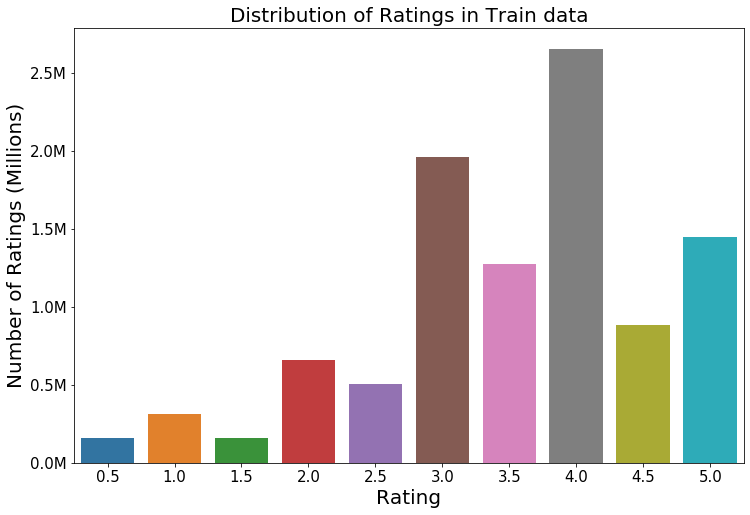

In [10]:
#Plotting a bar graph to visualise distribution of ratings in the train data
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in Train data", fontsize = 20)
plt.xlabel("Rating", fontsize = 20)
plt.ylabel("Number of Ratings (Millions)", fontsize = 20)
plt.show()

We can clearly see that Ratings equal to 4.0 are most common.

We believe that reasons for this might be because it is likely that people who truely enjoyed a specific movie will never be 100% satisfied with the movie. Giving a 5.0 rating would indicate a truly perfect movie from the watchers perspective, which is very rare. The closest best thing to 5.0 without seeming bias is 4.0, therefore 4.0 ratings are most common.

In [16]:
no_of_ratings_per_movie = train.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)

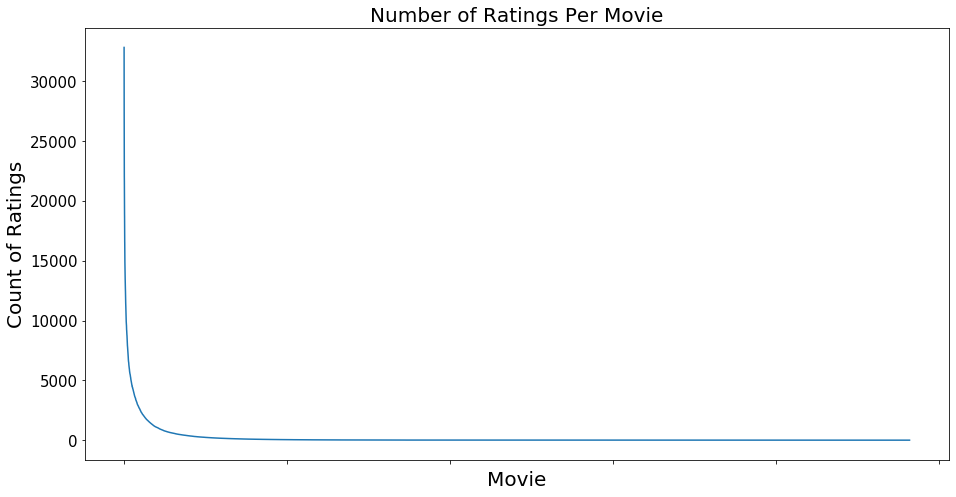

In [17]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

The above line graph shows that there are some movies that receive many ratings and some movies that receive very little votes.

We believe the reason for this can be the fact that some mainstream movies are way more popular and therefore receives a lot of attention compared to the other movies. 

In [15]:
no_of_rated_movies_per_user = train.groupby(by = "userId")["rating"].count().sort_values(ascending = False)
no_of_rated_movies_per_user.head(10)

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: rating, dtype: int64

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

# Collaborative Filtering

We will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

We will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. We can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

In [ ]:
#Run if running from colab
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 55kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675729 sha256=afd38a873a54448dca3c95fdd0016d9c1aeddbc629c0bbf83358d70b74121e86
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [ ]:
#Importing the surprise packages we need
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 5))

In [ ]:
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
cross_validate(NormalPredictor(), data, cv=2)

{'fit_time': (11.288833379745483, 16.53377676010132),
 'test_mae': array([1.15018508, 1.1510351 ]),
 'test_rmse': array([1.4424115, 1.4431462]),
 'test_time': (67.95609903335571, 65.65669322013855)}

In [ ]:
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8451
RMSE: 0.8459


In [ ]:
algo.fit(data.build_full_trainset())

Predicting on the whole testset.

In [ ]:
#This for loop generates a list containing all our predictions.
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings

In [ ]:
test['rating'] = ratings
test.head()

In [ ]:
test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)

In [ ]:
#Creating our submission csv file. Score of 0.81885.
test_df = test.copy()
test_df.drop(columns=['movieId', 'userId'], inplace=True)
test_df.to_csv('Submission_3.csv', index=False)
test_df

# Appendix A

This section contains things that might have not worked, our previous models and some testing we did. Feel free to have a look at everything we attempted. 


In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8891006904049262
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
from surprise.model_selection import train_test_split

# Setting the data variable and using the Reader() object.
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8883


0.8882637494815175

In [ ]:
# Using algorithm with best 'rmse'
algo = gs.best_estimator['rmse']

# Fitting it to our full trainset
algo.fit(data.build_full_trainset())

In [ ]:
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings

[3.573181312695559,
 4.034689109340559,
 3.6512148682619756,
 3.7651367294619744,
 3.375689872189256,
 3.8059993312153493,
 3.9147556424070125,
 3.719937523825239,
 3.8616090871435955,
 3.68721039182157,
 3.547382441994458,
 3.3229163686411725,
 3.7793228272267623,
 3.8415707438686195,
 3.771651894274973,
 3.904995116317711,
 3.7402415783017773,
 3.23720540913246,
 3.5205798358371783,
 3.621287474168504,
 3.8797194127927903,
 3.562730417800229,
 3.2235652855048125,
 3.3170799147532533,
 3.8147991087846127,
 3.729649503520648,
 3.7021427954556585,
 3.4520691361637876,
 3.4043245285097954,
 3.7005130051232613,
 3.799747542156323,
 3.611423778131383,
 3.5192427180235915,
 3.273328306965661,
 3.150292367609543,
 3.3444363414944713,
 3.649959463484169,
 3.7809338017826226,
 3.816272086440247,
 3.4413719483334217,
 3.6760084305664913,
 3.633142274384807,
 3.458845624922486,
 3.5128262951880744,
 3.7388861993013562,
 3.934888203336384,
 4.0169165764557215,
 4.261294047913114,
 4.0273511737456

In [ ]:
test['rating'] = ratings
test.head()

,userId,movieId,rating
0,1,2011,3.573181
1,1,4144,4.034689
2,1,5767,3.651215
3,1,6711,3.765137
4,1,7318,3.375690


In [ ]:
# test = pd.read_csv('test.csv')

In [ ]:
# test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)
test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [ ]:
#Converting the movieId column to str type. This allows us to join or columns contents with ease.
test['movieId'] = test['movieId'].astype(str)
test['movieId']

0          2011
1          4144
2          5767
3          6711
4          7318
           ... 
5000014    4079
5000015    4467
5000016    4980
5000017    5689
5000018    7153
Name: movieId, Length: 5000019, dtype: object

In [ ]:
#This for loop is simply used to remove '.0' from movieId in order to make it identical to the submission csv!
# meh = []
# for i in test['movieId']:
#   i = i[:-2]
#   meh.append(i)

# meh
test.head()

,userId,movieId,rating
0,1,2011,3.573181
1,1,4144,4.034689
2,1,5767,3.651215
3,1,6711,3.765137
4,1,7318,3.375690


In [ ]:
# test['movieId'] = meh
# test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)

In [ ]:
# test.dropna(inplace=True)
test.head()

,userId,movieId,rating,Id
0,1,2011,3.573181,1_2011
1,1,4144,4.034689,1_4144
2,1,5767,3.651215,1_5767
3,1,6711,3.765137,1_6711
4,1,7318,3.375690,1_7318


In [ ]:
len(test)

5000019

In [ ]:
test_df = test.copy()
test_df.head()

,userId,movieId,rating,Id
0,1,2011,3.573181,1_2011
1,1,4144,4.034689,1_4144
2,1,5767,3.651215,1_5767
3,1,6711,3.765137,1_6711
4,1,7318,3.375690,1_7318


In [ ]:
test_df.drop(columns=['movieId', 'userId'], inplace=True)
# test.head()
test_df.to_csv('Submission_2.csv', index=False)
test_df

,rating,Id
0,3.573181,1_2011
1,4.034689,1_4144
2,3.651215,1_5767
3,3.765137,1_6711
4,3.375690,1_7318
...,...,...
5000014,3.394499,162541_4079
5000015,3.610409,162541_4467
5000016,3.256278,162541_4980
5000017,3.141016,162541_5689


In [ ]:
sample.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [ ]:
# ratings = []
# for i in range(min(100, len(users_ids))):
#     for j in range(min(100, len(items_ids))):
#         ratings.append(algo.predict(users_ids[i], items_ids[j]).est)
# print len(set(ratings))


In [ ]:
# [i for i in test.iterrows()]

[(0, userId        1.0
  movieId    2011.0
  Name: 0, dtype: float64), (1, userId        1.0
  movieId    4144.0
  Name: 1, dtype: float64), (2, userId        1.0
  movieId    5767.0
  Name: 2, dtype: float64), (3, userId        1.0
  movieId    6711.0
  Name: 3, dtype: float64), (4, userId        1.0
  movieId    7318.0
  Name: 4, dtype: float64), (5, userId        1.0
  movieId    8405.0
  Name: 5, dtype: float64), (6, userId        1.0
  movieId    8786.0
  Name: 6, dtype: float64), (7, userId       2.0
  movieId    150.0
  Name: 7, dtype: float64), (8, userId       2.0
  movieId    356.0
  Name: 8, dtype: float64), (9, userId       2.0
  movieId    497.0
  Name: 9, dtype: float64), (10, userId       2.0
  movieId    588.0
  Name: 10, dtype: float64), (11, userId       2.0
  movieId    653.0
  Name: 11, dtype: float64), (12, userId        2.0
  movieId    1080.0
  Name: 12, dtype: float64), (13, userId        2.0
  movieId    1196.0
  Name: 13, dtype: float64), (14, userId        2.

In [ ]:
uid = str(test.iloc[:,:-1].values)
iid = str(test.iloc[:,-1].values)
uid

'[[    1]\n [    1]\n [    1]\n ...\n [22854]\n [22854]\n [   22]]'

In [ ]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.993054,0.993151,0.990496,0.992234,0.001229,7,0.775013,0.775300,0.773370,0.774561,0.000850,7,5.519943,0.772439,1.587330,0.276665,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",5,0.002,0.4
1,0.995758,0.996060,0.992963,0.994927,0.001394,8,0.779811,0.779895,0.778041,0.779249,0.000855,8,4.853417,0.034325,1.528982,0.219936,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",5,0.002,0.6
2,0.970135,0.970149,0.966875,0.969053,0.001540,3,0.755282,0.755261,0.753010,0.754518,0.001066,3,4.886498,0.020880,1.583549,0.268445,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",5,0.005,0.4
3,0.973999,0.974010,0.970796,0.972935,0.001513,4,0.761239,0.761263,0.759049,0.760517,0.001038,5,5.043566,0.164280,1.418149,0.258031,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",5,0.005,0.6
4,0.975586,0.975769,0.972843,0.974733,0.001338,5,0.760280,0.760187,0.758710,0.759725,0.000719,4,9.342871,0.108045,1.581257,0.229873,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",10,0.002,0.4
5,0.979268,0.979243,0.976694,0.978402,0.001207,6,0.765987,0.766041,0.764387,0.765471,0.000767,6,9.292656,0.044363,1.555506,0.247967,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.6}",10,0.002,0.6
6,0.953947,0.954159,0.950827,0.952978,0.001523,1,0.741951,0.742139,0.739845,0.741312,0.001040,1,9.280040,0.068097,1.560780,0.242003,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4
7,0.958886,0.959029,0.956025,0.957980,0.001384,2,0.748771,0.748727,0.746814,0.748104,0.000912,2,9.150445,0.028648,1.502130,0.220085,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}",10,0.005,0.6


Looking at the other data:

In [ ]:
movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
sample.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [ ]:
test = test.dropna()

In [ ]:
test

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0
...,...,...
694261,22854,79879.0
694262,22854,80693.0
694263,22854,80831.0
694264,22854,81591.0


In [ ]:
train.head(50)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1.518350e+09
1,106343,5,4.5,1.206239e+09
2,146790,5459,5.0,1.076216e+09
3,106362,32296,2.0,1.423043e+09
4,9041,366,3.0,8.333758e+08
5,120949,81768,3.0,1.289595e+09
6,19630,62049,4.0,1.246730e+09
7,21066,2282,1.0,9.457859e+08
8,117563,120474,4.0,1.515108e+09
9,144018,1997,5.0,1.109968e+09


In [ ]:
# train_df = pd.merge(train, movies, on='movieId')
# train_df.shape

(1364368, 6)

In [ ]:
genome_scores.shape

(1342991, 3)

In [ ]:
tags.shape

(1006943, 4)

In [ ]:
genome_tags.shape

(1128, 2)

In [ ]:
imdb_data.shape

(27278, 6)

In [ ]:
links.shape

(62423, 3)

In [ ]:
sample.head(25)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0
5,1_8405,1.0
6,1_8786,1.0
7,2_150,1.0
8,2_356,1.0
9,2_497,1.0


In [ ]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1.518350e+09
1,106343,5,4.5,1.206239e+09
2,146790,5459,5.0,1.076216e+09
3,106362,32296,2.0,1.423043e+09
4,9041,366,3.0,8.333758e+08


In [ ]:
len(train)

280926

In [ ]:
len(test)

694267

In [ ]:
len(sample)

509904